In [322]:
import csv
import lzstring
from collections import namedtuple, Counter
import json
from memoize import memoize
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sys
import json

In [323]:
csv.field_size_limit(sys.maxsize)

# [num unique urls, num unique urls typed, total visits, total typed, first visit time, last visit time]
domaininfo = namedtuple('domaininfo', ['num_unique_urls', 'num_unique_urls_typed', 'total_visits', 'total_typed', 'first_visit_time', 'last_visit_time'])

decompressFromEncodedURIComponent = lzstring.LZString().decompressFromEncodedURIComponent

#filepath = 'difficultyselectionexp_may31_11am.csv'
filepath = 'data/difficultyselectionexp_june25_9pm.csv'
reader = csv.DictReader(open(filepath))

def extract_domain_visit_info(domain_visit_info_compressed):
  domain_visit_info = json.loads(decompressFromEncodedURIComponent(domain_visit_info_compressed))
  output = {}
  for k,v in domain_visit_info.items():
    linedata = domaininfo(*v)
    output[k] = linedata
  return output

alldata = []

for alldata_item in reader:
  if alldata_item['selected_difficulty'] not in ['nothing', 'easy', 'medium', 'hard']:
    continue
  if alldata_item['domain_visit_info_compressed'] == None or len(alldata_item['domain_visit_info_compressed']) == 0:
    continue
  alldata_item['domain_visit_info'] = extract_domain_visit_info(alldata_item['domain_visit_info_compressed'])
  alldata.append(alldata_item)


In [324]:
#np.random.shuffle(alldata)
training_data = alldata[:round(len(alldata)*0.8)]
test_data = alldata[round(len(alldata)*0.8):]
print(len(training_data))
print(len(test_data))

346
86


In [325]:
def extract_labels_alldata(data):
  return np.array([line['selected_difficulty'] for line in data])

@memoize
def get_most_common_label():
  label_to_count = Counter()
  for line in training_data:
    label = line['selected_difficulty']
    label_to_count[label] += 1
  sorted_by_count = sorted(label_to_count.items(), key=lambda x: x[1], reverse=True)
  return sorted_by_count[0][0]

@memoize
def get_most_visited_domains():
  domain_to_num_visits = Counter()
  for line in training_data:
    domain_visit_info = line['domain_visit_info']
    for domain,info in domain_visit_info.items():
      domain_to_num_visits[domain] += info.total_visits
  sorted_by_num_visits = sorted(domain_to_num_visits.items(), key=lambda x: x[1], reverse=True)
  return [x[0] for x in sorted_by_num_visits[:100]]

cnt = 0
@memoize
def get_most_common_domains():
  domain_to_num_visits = Counter()
  for line in training_data:
    domain_visit_info = line['domain_visit_info']
    for domain,info in domain_visit_info.items():
      domain_to_num_visits[domain] += 1
  sorted_by_num_visits = sorted(domain_to_num_visits.items(), key=lambda x: x[1], reverse=True)
  return [x[0] for x in sorted_by_num_visits[:100]]

def get_all_domains():
  domain_to_num_visits = Counter()
  for line in training_data:
    domain_visit_info = line['domain_visit_info']
    for domain,info in domain_visit_info.items():
      domain_to_num_visits[domain] += 1
  sorted_by_num_visits = sorted(domain_to_num_visits.items(), key=lambda x: x[1], reverse=True)
  return [x[0] for x in sorted_by_num_visits]



def get_num_visits_for_domain(domain_visit_info, domain):
  info = domain_visit_info.get(domain, None)
  if info != None:
    return info.total_visits
  return 0

def get_productivity():
    with open ('domain_to_productivity.json') as json_file:
        data = json.load(json_file)
        return data

domain_to_productivity = get_productivity()

def extract_features_for_user(domain_visit_info):
  cnt = 0
  domains = get_all_domains()
  final_features = [0, 0, 0, 0, 0];
  for x in domains:
        if x in domain_to_productivity.keys():
            final_features[domain_to_productivity[x] + 2] += get_num_visits_for_domain(domain_visit_info, x)
    
  #np.array([get_num_visits_for_domain(domain_visit_info, x) for x in domains])
  #if np.sum(final_features) >= 1:
    #final_features = np.divide(final_features, np.sum(final_features))
  return final_features

def extract_features_alldata(data):
  output = []
  for line in data:
    domain_visit_info = line['domain_visit_info']
    features = extract_features_for_user(domain_visit_info)
    output.append(features)
  return np.array(output)


In [326]:
def get_percent_correct(predicted_labels, actual_labels):
  if len(predicted_labels) != len(actual_labels):
    raise 'need predicted and actual labels to have same lengths'
  total = len(actual_labels)
  correct = 0
  for p,a in zip(predicted_labels, actual_labels):
    if p == a:
      correct += 1
  return correct / total

def test_baseline_classifier():
  most_common_label = get_most_common_label()
  predictions = [most_common_label for line in test_data]
  actual = extract_labels_alldata(test_data)
  percent_correct = get_percent_correct(predictions, actual)
  print('baseline classifier accuracy:', percent_correct)

def test_classifier(clf,features_test, actual, str=None):
  #actual = extract_labels_alldata(test_data)
  #features_test = extract_features_alldata(test_data)
  predictions = clf.predict(features_test)
  percent_correct = get_percent_correct(predictions, actual)
  return percent_correct

def training_error_classifier(clf, str=None):
  actual = extract_labels_alldata(training_data)
  features_train = extract_features_alldata(training_data)
  predictions = clf.predict(features_train)
  percent_correct = get_percent_correct(predictions, actual)
  print(str + ' classifier training accuracy:', round(percent_correct, 2))

def to_int_categorical(dt):
  # {'easy', 'hard', 'medium', 'nothing'}
  cat_dt = []
  for item in dt:
    if item == 'nothing':
      cat_dt.append(0)
    elif item == 'easy':
      cat_dt.append(1)
    elif item == 'medium':
      cat_dt.append(2)
    else:
      cat_dt.append(3)
  return np.array(cat_dt)
    
test_baseline_classifier()

baseline classifier accuracy: 0.4186046511627907


In [401]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import regularizers

labels_test2 = to_categorical(to_int_categorical(extract_labels_alldata(test_data)), num_classes=4)
features_test2 = extract_features_alldata(test_data)

labels_train2 = to_categorical(to_int_categorical(extract_labels_alldata(training_data)), num_classes=4)
features_train2 = extract_features_alldata(training_data)

In [494]:
labels_test = labels_test2
features_test = features_test2
labels_train = labels_train2
features_train = features_train2

In [495]:
features_train = np.divide (features_train, 100 * 10)
features_test = np.divide (features_test, 100 * 10)

In [496]:
def nn():
    model = Sequential()
    l2 = 0.005
    drp = 0
    
    model.add(Dense(2 * 32, activation='relu', input_dim=5, kernel_regularizer=regularizers.l2(0)))
    model.add(Dropout(drp))
    model.add(Dense(2 * 64, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(drp))
    #model.add(Dense(2 * 128, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    #model.add(Dropout(drp))
    #model.add(Dense(2 * 256, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    #model.add(Dropout(drp))
    #model.add(Dense(2 * 256, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    #model.add(Dropout(drp))
    #model.add(Dense(2 * 128, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    #model.add(Dropout(drp))
    model.add(Dense(2 * 64, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(drp))
    model.add(Dense(2 * 32, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(drp))
    model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(l2)))

    sgd = SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

    model.fit(features_train, labels_train,
          epochs=500, verbose=0)
    training_score = model.evaluate(features_train, labels_train, batch_size=32)
    score = model.evaluate(features_test, labels_test, batch_size=32)

    predictions = model.predict(features_test, batch_size=32)
    
    print(training_score)
    #print(predictions)
    #print(labels_test)
    print(score)
    return score

In [497]:
print (nn())

86/86 [==============================] - 0s 137us/step
[1.1120278332274773, 0.6040462424300309]
[1.7885209211083346, 0.4534883755584096]
[1.7885209211083346, 0.4534883755584096]


In [500]:
features_train2 = np.divide (features_train2, 100 * 10)
features_test2 = np.divide (features_test2, 100 * 10)

In [501]:

num = 30
cache = []
training_size = []
for i in range(30):
    labels_train = labels_train2[: max(3, round(len(labels_train2)*((i + 1) / num)))]
    features_train = features_train2[: max(3, round(len(features_train2)*((i + 1) / num)))]
    labels_test = labels_test2[: max(3, round(len(labels_test2)*((i + 1) / num)))]
    features_test = features_test2[: max(3, round(len(features_test2)*((i + 1) / num)))]
    score = nn()
    cache.append(score[1])
    training_size.append(len(labels_train))
    
    
    

3/3 [==============================] - 0s 2ms/step
[0.76789391040802, 1.0]
[9.413142204284668, 0.3333333432674408]
6/6 [==============================] - 0s 1ms/step
[0.947800874710083, 0.9130434989929199]
[8.63028335571289, 0.1666666716337204]
9/9 [==============================] - 0s 756us/step
[0.679997821365084, 0.8857142857142857]
[2.9051547050476074, 0.1111111119389534]
11/11 [==============================] - 0s 477us/step
[0.6991879292156385, 0.8913043400515681]
[2.606843948364258, 0.27272728085517883]
14/14 [==============================] - 0s 511us/step
[0.7724455471696525, 0.862068957295911]
[3.708728313446045, 0.2857142984867096]
17/17 [==============================] - 0s 348us/step
[1.2600615015928296, 0.6811594220175259]
[3.3505563735961914, 0.23529411852359772]
20/20 [==============================] - 0s 175us/step
[0.7809231178260144, 0.8395061765188052]
[3.394136905670166, 0.20000000298023224]
23/23 [==============================] - 0s 211us/step
[1.088756571645322,

In [502]:
import matplotlib.pyplot as plt

learning curve for Neural net:


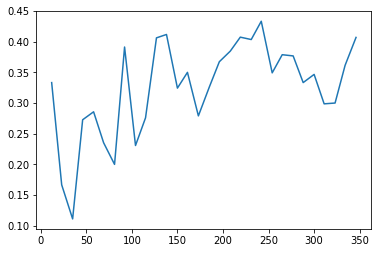

In [505]:
print ("learning curve for Neural net:")

plt.plot(training_size, cache)